# Step 1: Import the required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# Проверяем, доступен ли GPU, и устанавливаем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Используется устройство: cuda


# Step 2: Define image transformations

In [2]:
# Определяем преобразования для изображений CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(), # Преобразуем изображение в тензор PyTorch (от 0 до 1)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Нормализуем значения пикселей до диапазона [-1, 1]
])

# Step 3: Loading CIFAR-10 dataset

In [3]:
# Загружаем обучающий набор данных CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Создаем загрузчик данных для обработки мини-пакетов
batch_size = 32
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Загружено {len(train_dataset)} изображений в {len(dataloader)} пакетах.")

100%|██████████| 170M/170M [00:06<00:00, 25.5MB/s]


Загружено 50000 изображений в 1563 пакетах.


# Step 4: Defining hyperparameters

In [4]:
# Гиперпараметры для GAN
latent_dim = 100 # Размерность вектора шума
lr = 0.0002      # Скорость обучения
beta1 = 0.5      # Коэффициент Adam для момента
beta2 = 0.999    # Коэффициент Adam для RMSProp
num_epochs = 20  # Общее количество эпох обучения (увеличим до 20 для лучшего результата)

# Step 5: Creating the Generator Architecture

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8), # Линейный слой, расширяющий шум
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)), # Преобразование в 3D-тензор (карту признаков)
            nn.Upsample(scale_factor=2), # Повышаем разрешение до 16x16
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # Повышаем разрешение до 32x32
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1), # Финальный свёрточный слой для 3 каналов RGB
            nn.Tanh() # Активация Tanh, чтобы выход был в диапазоне [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img

# Выводим сводку архитектуры, чтобы убедиться, что все правильно
generator = Generator(latent_dim).to(device)
print("Архитектура Генератора:")
print(generator)

Архитектура Генератора:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 8, 8))
    (3): Upsample(scale_factor=2.0, mode='nearest')
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.78, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Upsample(scale_factor=2.0, mode='nearest')
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.78, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): Tanh()
  )
)


# Step 6: Create the Discriminator architecture

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 1), # Линейный слой, который выводит одно значение
            nn.Sigmoid() # Активация Sigmoid для получения вероятности от 0 до 1
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Выводим сводку архитектуры
discriminator = Discriminator().to(device)
print("\nАрхитектура Дискриминатора:")
print(discriminator)


Архитектура Дискриминатора:
Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ZeroPad2d((0, 1, 0, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.82, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.25)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.82, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.25)
    (15): Dropout(p=0.25, inplace=False)
   

# Step 7: Initialize the training components

In [7]:
# Функция потерь: двоичная кросс-энтропия
adversarial_loss = nn.BCELoss()

# Оптимизаторы для генератора и дискриминатора
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
print("\nКомпоненты обучения инициализированы.")


Компоненты обучения инициализированы.


# Step 8: GAN Training Cycle

Эпоха [1/20] Пакет [100/1563] Потери дискриминатора: 0.5512 Потери генератора: 1.2941
Эпоха [1/20] Пакет [200/1563] Потери дискриминатора: 0.7177 Потери генератора: 1.1233
Эпоха [1/20] Пакет [300/1563] Потери дискриминатора: 0.5340 Потери генератора: 1.1971
Эпоха [1/20] Пакет [400/1563] Потери дискриминатора: 0.8000 Потери генератора: 1.0452
Эпоха [1/20] Пакет [500/1563] Потери дискриминатора: 0.6827 Потери генератора: 0.7463
Эпоха [1/20] Пакет [600/1563] Потери дискриминатора: 0.6738 Потери генератора: 1.0186
Эпоха [1/20] Пакет [700/1563] Потери дискриминатора: 0.6407 Потери генератора: 1.0289
Эпоха [1/20] Пакет [800/1563] Потери дискриминатора: 0.6471 Потери генератора: 0.9129
Эпоха [1/20] Пакет [900/1563] Потери дискриминатора: 0.6678 Потери генератора: 1.0959
Эпоха [1/20] Пакет [1000/1563] Потери дискриминатора: 0.6643 Потери генератора: 1.2493
Эпоха [1/20] Пакет [1100/1563] Потери дискриминатора: 0.6223 Потери генератора: 0.9837
Эпоха [1/20] Пакет [1200/1563] Потери дискриминатора

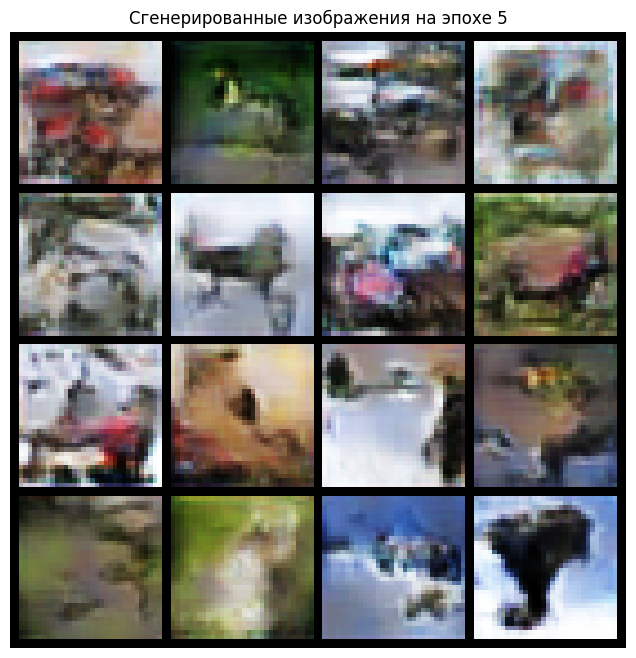

Эпоха [6/20] Пакет [100/1563] Потери дискриминатора: 0.6019 Потери генератора: 1.3034
Эпоха [6/20] Пакет [200/1563] Потери дискриминатора: 0.8999 Потери генератора: 0.8596
Эпоха [6/20] Пакет [300/1563] Потери дискриминатора: 0.6251 Потери генератора: 1.0718
Эпоха [6/20] Пакет [400/1563] Потери дискриминатора: 0.4764 Потери генератора: 1.4880
Эпоха [6/20] Пакет [500/1563] Потери дискриминатора: 0.9408 Потери генератора: 1.2508
Эпоха [6/20] Пакет [600/1563] Потери дискриминатора: 0.6711 Потери генератора: 1.5816
Эпоха [6/20] Пакет [700/1563] Потери дискриминатора: 0.7580 Потери генератора: 1.2089
Эпоха [6/20] Пакет [800/1563] Потери дискриминатора: 0.5570 Потери генератора: 1.3349
Эпоха [6/20] Пакет [900/1563] Потери дискриминатора: 0.5733 Потери генератора: 1.2925
Эпоха [6/20] Пакет [1000/1563] Потери дискриминатора: 0.5049 Потери генератора: 0.9671
Эпоха [6/20] Пакет [1100/1563] Потери дискриминатора: 0.6278 Потери генератора: 1.1455
Эпоха [6/20] Пакет [1200/1563] Потери дискриминатора

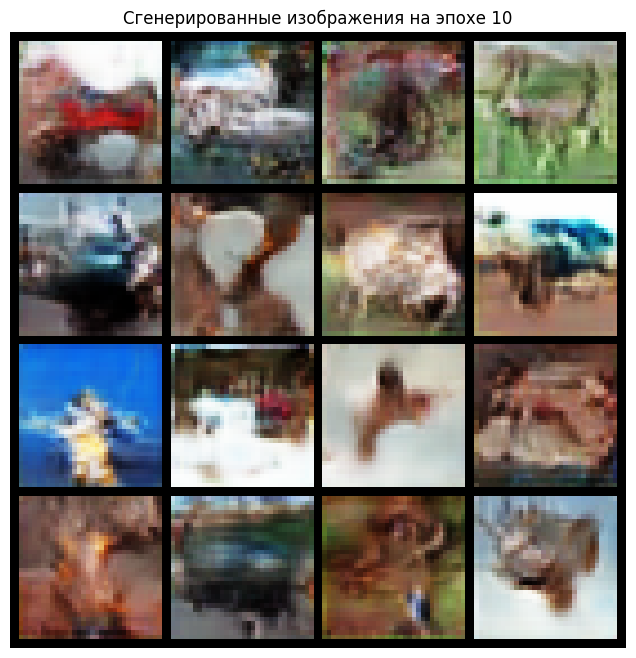

Эпоха [11/20] Пакет [100/1563] Потери дискриминатора: 0.3401 Потери генератора: 1.2917
Эпоха [11/20] Пакет [200/1563] Потери дискриминатора: 0.6366 Потери генератора: 0.9507
Эпоха [11/20] Пакет [300/1563] Потери дискриминатора: 0.6824 Потери генератора: 0.7595
Эпоха [11/20] Пакет [400/1563] Потери дискриминатора: 0.4832 Потери генератора: 1.0634
Эпоха [11/20] Пакет [500/1563] Потери дискриминатора: 0.5506 Потери генератора: 1.0109
Эпоха [11/20] Пакет [600/1563] Потери дискриминатора: 0.7705 Потери генератора: 0.9365
Эпоха [11/20] Пакет [700/1563] Потери дискриминатора: 0.4798 Потери генератора: 0.9419
Эпоха [11/20] Пакет [800/1563] Потери дискриминатора: 0.8852 Потери генератора: 1.4867
Эпоха [11/20] Пакет [900/1563] Потери дискриминатора: 0.6965 Потери генератора: 0.8823
Эпоха [11/20] Пакет [1000/1563] Потери дискриминатора: 0.7069 Потери генератора: 2.0375
Эпоха [11/20] Пакет [1100/1563] Потери дискриминатора: 0.7113 Потери генератора: 1.7709
Эпоха [11/20] Пакет [1200/1563] Потери ди

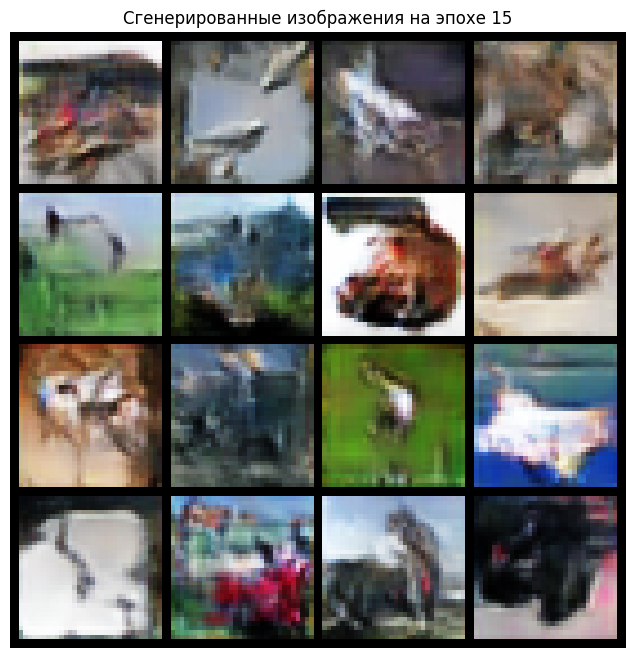

Эпоха [16/20] Пакет [100/1563] Потери дискриминатора: 0.4142 Потери генератора: 0.7157
Эпоха [16/20] Пакет [200/1563] Потери дискриминатора: 0.4167 Потери генератора: 1.7086
Эпоха [16/20] Пакет [300/1563] Потери дискриминатора: 0.5452 Потери генератора: 1.5611
Эпоха [16/20] Пакет [400/1563] Потери дискриминатора: 0.4776 Потери генератора: 1.3547
Эпоха [16/20] Пакет [500/1563] Потери дискриминатора: 0.5511 Потери генератора: 1.3906
Эпоха [16/20] Пакет [600/1563] Потери дискриминатора: 0.7018 Потери генератора: 2.6713
Эпоха [16/20] Пакет [700/1563] Потери дискриминатора: 0.4285 Потери генератора: 1.3485
Эпоха [16/20] Пакет [800/1563] Потери дискриминатора: 0.5593 Потери генератора: 1.7162
Эпоха [16/20] Пакет [900/1563] Потери дискриминатора: 0.3856 Потери генератора: 1.9395
Эпоха [16/20] Пакет [1000/1563] Потери дискриминатора: 0.6266 Потери генератора: 1.6242
Эпоха [16/20] Пакет [1100/1563] Потери дискриминатора: 0.7681 Потери генератора: 1.2486
Эпоха [16/20] Пакет [1200/1563] Потери ди

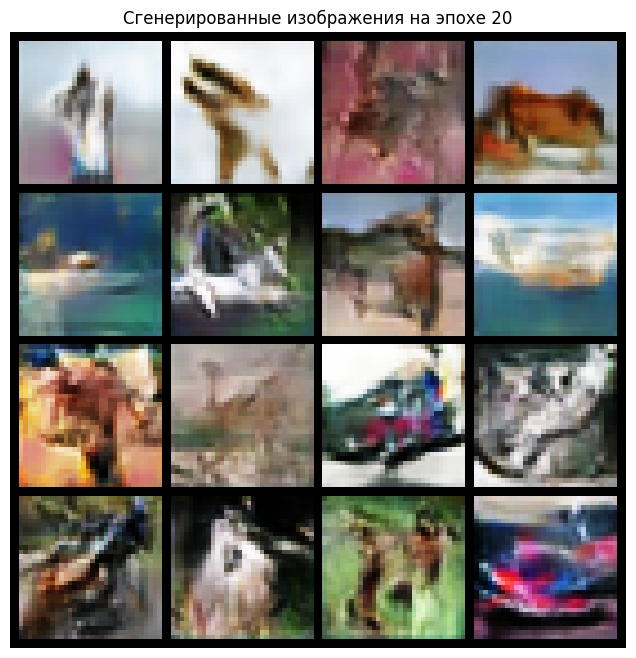

Обучение завершено.


In [8]:
# Список для хранения потерь
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        real_images = batch[0].to(device)
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        # ---------------------
        # Обучение Дискриминатора
        # ---------------------
        optimizer_D.zero_grad()

        # 1. Потери для реальных изображений
        real_loss = adversarial_loss(discriminator(real_images), valid)

        # 2. Потери для поддельных изображений
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake) # .detach() важен!

        # Общие потери дискриминатора
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Обучение Генератора
        # -----------------
        optimizer_G.zero_grad()

        # Генератор хочет, чтобы дискриминатор считал его изображения реальными
        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Мониторинг прогресса
        # ---------------------
        if (i + 1) % 100 == 0:
            print(f"Эпоха [{epoch+1}/{num_epochs}] Пакет [{i+1}/{len(dataloader)}] "
                  f"Потери дискриминатора: {d_loss.item():.4f} "
                  f"Потери генератора: {g_loss.item():.4f}")

    # Сохраняем значения потерь для каждой эпохи
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    # Визуализируем сгенерированные изображения в конце каждой эпохи
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)

            plt.figure(figsize=(8,8))
            plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
            plt.title(f"Сгенерированные изображения на эпохе {epoch+1}")
            plt.axis("off")
            plt.show()

print("Обучение завершено.")